In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp

In [3]:
df_info = pd.read_csv('selected_esg_scores.csv') 
df_price = pd.read_csv('yahoo_all_stocks_10y_merged.csv') 
df_price['Date'] = pd.to_datetime(df_price['Date']) 
df_price = df_price.set_index('Date', inplace=False) 
# Ensure tickers exist 
tickers = df_info['Ticker'].dropna().unique().tolist()
missing = [t for t in tickers if t not in df_price.columns] 
if missing: 
    print("Missing tickers:", missing) 
    tickers = [t for t in tickers if t in df_price.columns] 
    
df_price = df_price[tickers].astype(float) 
df_return = np.log(df_price / df_price.shift(1)).dropna() 
df_return = df_return[tickers] 
df_cov = df_return.cov() 

display(df_info) 
display(df_price) 
display(df_return)
display(df_cov)

,Ticker,Category,ESG_Score
0,CHTR,Communication Services,24.72
1,CMCSA,Communication Services,23.09
2,DIS,Communication Services,15.70
3,EA,Communication Services,13.29
4,GOOGL,Communication Services,24.22
5,AMZN,Consumer Discretionary,30.61
6,APTV,Consumer Discretionary,10.66
7,AZO,Consumer Discretionary,11.02
8,BBWI,Consumer Discretionary,28.30
9,BBY,Consumer Discretionary,15.89


,CHTR,CMCSA,DIS,EA,GOOGL,AMZN,APTV,AZO,BBWI,BBY,...,AMT,ARE,AVB,BXP,CBRE,AEE,AEP,AES,ATO,AWK
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-24,181.889999,22.612652,97.575058,67.039673,38.004845,33.139500,69.302429,740.559998,55.236309,21.206678,...,77.558159,64.426903,131.065613,85.908974,34.740002,32.560146,41.016960,6.590806,49.829704,49.337078
2015-12-28,182.080002,22.569250,98.856270,67.273010,38.818699,33.759998,69.573738,741.869995,55.145042,21.227541,...,77.739952,64.979256,131.904816,86.315208,34.730000,32.828510,41.157425,6.508251,50.657974,49.980286
2015-12-29,185.169998,22.715269,98.699570,67.914711,39.400311,34.698502,69.932861,749.179993,55.841038,21.380503,...,78.561829,65.700508,133.991928,87.734398,35.130001,32.888142,41.361099,6.611444,50.681637,49.972038
2015-12-30,184.220001,22.379820,98.017494,67.720276,39.218674,34.453499,69.062988,750.169983,55.150723,21.178864,...,77.526543,65.264915,133.832993,86.909897,34.639999,32.798687,41.368122,6.535768,50.602753,49.848347
2015-12-31,183.100006,22.269323,96.856102,66.816017,38.608784,33.794498,68.416565,741.909973,54.665787,21.171919,...,76.617729,64.529327,132.973648,86.193535,34.580002,32.224716,40.925652,6.583927,49.727154,49.271122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-15,209.520004,28.209999,110.489998,204.199997,308.220001,222.539993,77.349998,3488.709961,19.719999,71.940002,...,180.259995,47.410000,177.789993,71.620003,158.869995,98.870003,115.769997,13.860000,170.750000,134.130005
2025-12-16,211.289993,29.730000,111.620003,204.199997,306.570007,222.559998,77.419998,3417.419922,19.639999,72.620003,...,179.130005,46.970001,176.940002,70.699997,160.699997,97.989998,114.570000,13.620000,168.000000,132.720001
2025-12-17,209.660004,30.320000,110.629997,203.630005,296.720001,221.270004,76.750000,3393.350098,19.670000,71.449997,...,178.490005,47.560001,181.259995,69.540001,160.009995,98.529999,114.709999,13.480000,169.169998,134.009995


,CHTR,CMCSA,DIS,EA,GOOGL,AMZN,APTV,AZO,BBWI,BBY,...,AMT,ARE,AVB,BXP,CBRE,AEE,AEP,AES,ATO,AWK
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-28,0.001044,-0.001921,0.013045,0.003475,0.021188,0.018551,0.003907,0.001767,-0.001654,0.000983,...,0.002341,0.008537,0.006383,0.004718,-0.000288,0.008208,0.003419,-0.012605,0.016485,0.012953
2015-12-29,0.016828,0.006449,-0.001586,0.009494,0.014872,0.027420,0.005148,0.009805,0.012542,0.007180,...,0.010517,0.011039,0.015699,0.016308,0.011452,0.001815,0.004936,0.015731,0.000467,-0.000165
2015-12-30,-0.005144,-0.014878,-0.006935,-0.002867,-0.004621,-0.007086,-0.012517,0.001321,-0.012439,-0.009476,...,-0.013266,-0.006652,-0.001187,-0.009442,-0.014046,-0.002724,0.000170,-0.011512,-0.001558,-0.002478
2015-12-31,-0.006098,-0.004950,-0.011920,-0.013443,-0.015673,-0.019313,-0.009404,-0.011072,-0.008832,-0.000328,...,-0.011792,-0.011335,-0.006442,-0.008277,-0.001734,-0.017655,-0.010754,0.007342,-0.017455,-0.011647
2016-01-04,-0.030893,-0.009658,-0.020187,-0.038871,-0.024158,-0.059276,-0.020505,-0.008705,-0.019176,0.006546,...,-0.002582,-0.013930,-0.018693,-0.026537,-0.014271,-0.004637,0.001029,-0.014737,-0.010685,0.009494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-15,0.014035,0.035357,-0.003253,0.002304,-0.003466,-0.016269,-0.018319,0.012402,-0.016596,-0.007790,...,-0.002438,0.016375,0.005018,0.002936,-0.004459,0.016315,0.014267,0.002167,0.014037,0.019422
2025-12-16,0.008412,0.052480,0.010175,0.000000,-0.005368,0.000090,0.000905,-0.020646,-0.004065,0.009408,...,-0.006288,-0.009324,-0.004792,-0.012929,0.011453,-0.008940,-0.010419,-0.017468,-0.016237,-0.010568
2025-12-17,-0.007744,0.019651,-0.008909,-0.002795,-0.032657,-0.005813,-0.008692,-0.007068,0.001526,-0.016243,...,-0.003579,0.012483,0.024122,-0.016543,-0.004303,0.005496,0.001221,-0.010332,0.006940,0.009673


,CHTR,CMCSA,DIS,EA,GOOGL,AMZN,APTV,AZO,BBWI,BBY,...,AMT,ARE,AVB,BXP,CBRE,AEE,AEP,AES,ATO,AWK
CHTR,0.000429,0.000208,0.000131,0.000092,0.000116,0.000122,0.000164,0.000082,0.000177,0.000132,...,0.000106,0.000125,0.000092,0.000120,0.000141,0.000073,0.000062,0.000103,0.000066,0.000083
CMCSA,0.000208,0.000266,0.000146,0.000077,0.000110,0.000106,0.000159,0.000083,0.000155,0.000129,...,0.000082,0.000107,0.000096,0.000124,0.000139,0.000073,0.000064,0.000112,0.000071,0.000081
DIS,0.000131,0.000146,0.000321,0.000064,0.000135,0.000145,0.000220,0.000087,0.000223,0.000168,...,0.000076,0.000120,0.000113,0.000161,0.000190,0.000063,0.000055,0.000155,0.000069,0.000063
EA,0.000092,0.000077,0.000064,0.000328,0.000114,0.000132,0.000105,0.000048,0.000064,0.000083,...,0.000077,0.000071,0.000056,0.000056,0.000088,0.000051,0.000047,0.000078,0.000049,0.000062
GOOGL,0.000116,0.000110,0.000135,0.000114,0.000331,0.000241,0.000200,0.000071,0.000165,0.000137,...,0.000083,0.000110,0.000089,0.000116,0.000157,0.000052,0.000041,0.000128,0.000051,0.000061
AMZN,0.000122,0.000106,0.000145,0.000132,0.000241,0.000428,0.000198,0.000059,0.000164,0.000158,...,0.000081,0.000113,0.000077,0.000106,0.000149,0.000039,0.000031,0.000112,0.000038,0.000053
APTV,0.000164,0.000159,0.000220,0.000105,0.000200,0.000198,0.000671,0.000126,0.000369,0.000280,...,0.000110,0.000171,0.000162,0.000243,0.000291,0.000061,0.000044,0.000263,0.000059,0.000059
AZO,0.000082,0.000083,0.000087,0.000048,0.000071,0.000059,0.000126,0.000273,0.000161,0.000124,...,0.000079,0.000088,0.000092,0.000098,0.000111,0.000078,0.000063,0.000088,0.000071,0.000078
BBWI,0.000177,0.000155,0.000223,0.000064,0.000165,0.000164,0.000369,0.000161,0.001134,0.000335,...,0.000101,0.000201,0.000170,0.000260,0.000306,0.000080,0.000052,0.000246,0.000084,0.000077
BBY,0.000132,0.000129,0.000168,0.000083,0.000137,0.000158,0.000280,0.000124,0.000335,0.000571,...,0.000085,0.000144,0.000124,0.000181,0.000203,0.000069,0.000062,0.000182,0.000073,0.000072


In [5]:
# Filter df_info to only those tickers we have returns for
df_info = df_info[df_info["Ticker"].isin(df_return.columns)].copy()

# Annualized return (log returns)
mu = df_return.mean() * 252

# Annualized volatility
sigma = df_return.std() * np.sqrt(252)

# Sharpe ratio (risk-free = 0)
sharpe = mu / sigma.replace(0, np.nan)

df_metrics = pd.DataFrame({
    "Ticker": df_return.columns,
    "Return": mu.values,
    "Volatility": sigma.values,
    "Sharpe": sharpe.values
})

# Merge with ESG info
df_topsis = df_info.merge(df_metrics, on="Ticker")


In [7]:
def topsis(df, weights, types):
    norm = df / np.sqrt((df**2).sum())

    weighted = norm * weights

    ideal_best = np.max(weighted, axis=0) * (types == 1) + np.min(weighted, axis=0) * (types == -1)
    ideal_worst = np.min(weighted, axis=0) * (types == 1) + np.max(weighted, axis=0) * (types == -1)

    dist_best = np.sqrt(((weighted - ideal_best)**2).sum(axis=1))
    dist_worst = np.sqrt(((weighted - ideal_worst)**2).sum(axis=1))

    return dist_worst / (dist_best + dist_worst + 1e-12)


criteria = df_topsis[["ESG_Score", "Return", "Volatility", "Sharpe"]].astype(float)

weights = np.array([0.4, 0.25, 0.2, 0.15])
weights = weights / weights.sum()

types = np.array([1, 1, -1, 1])

df_topsis["TOPSIS_score"] = topsis(criteria, weights, types)

# Choose top N
# top_n = 30
# selected_tickers = df_topsis.sort_values("TOPSIS_score", ascending=False).head(top_n)["Ticker"].tolist()

selected_tickers = df_topsis[df_topsis["TOPSIS_score"] > 0.6]["Ticker"].tolist()

df_info_sel = df_info[df_info["Ticker"].isin(selected_tickers)].copy()

df_return_sel = df_return[selected_tickers]
df_cov_sel = df_return_sel.cov()
mu_sel = df_return_sel.mean() * 252


In [9]:
# --- INPUTS (after TOPSIS selection) ---
n_assets = len(selected_tickers)
ones_vec = np.ones(n_assets)

# Annualized return of selected tickers
mu = mu_sel.values

# Covariance matrix of selected tickers (annualized)
Sigma = df_cov_sel.values * 252
Sigma = 0.5 * (Sigma + Sigma.T)

# Add tiny noise if singular
Sigma += np.eye(n_assets) * 1e-6

Sigma_inv = np.linalg.inv(Sigma)

# ESG & Sector info for selected tickers
esg = df_info_sel["ESG_Score"].astype(int).values
sectors = df_info_sel["Category"].tolist()
unique_sectors = sorted(set(sectors))

# --- Markowitz parameters ---
A = ones_vec @ Sigma_inv @ mu
B = mu.T @ Sigma_inv @ mu
C = ones_vec @ Sigma_inv @ ones_vec
D = B * C - A**2

g = (B * Sigma_inv @ ones_vec - A * Sigma_inv @ mu) / D
h = (C * Sigma_inv @ mu - A * Sigma_inv @ ones_vec) / D

w_min = Sigma_inv @ ones_vec / C
r_min = w_min @ mu

print("Number of selected tickers:", len(selected_tickers))
print("Minimum variance return:", r_min)
print("Minimum variance weights:\n", w_min)


Number of selected tickers: 14
Minimum variance return: 0.14286663233248212
Minimum variance weights:
 [ 0.06400053  0.08633665 -0.06614598  0.15773225 -0.04167398  0.0661074
  0.12310335  0.14100596  0.11359471  0.03579123 -0.00817218 -0.02575685
  0.14820429  0.20587263]


In [11]:
# --- Use TOPSIS-selected data ---
Sigma_np = df_cov_sel.values * 252          # annualized covariance
mu_np = mu_sel.values                       # annualized return
n = len(mu_np)

frontier = []

# Optimization Variables and Parameter
w = cp.Variable(n)
target_return_param = cp.Parameter()

# Objective: minimize portfolio variance
prob_obj = cp.Minimize(cp.quad_form(w, Sigma_np))

# Constraints
constraints = [
    cp.sum(w) == 1,
    w @ mu_np == target_return_param,
    w >= 0.0001,   # long-only + avoids tiny negative weights
    w <= 1
]

prob = cp.Problem(prob_obj, constraints)

# Build frontier
for tr in tqdm(np.linspace(mu_np.min(), mu_np.max(), 100), desc="Building frontier"):
    target_return_param.value = tr
    
    try:
        prob.solve(solver=cp.OSQP, warm_start=True)
        
        if prob.status == cp.OPTIMAL:
            w_val = w.value
            port_return = float(w_val @ mu_np)
            port_var = float(cp.quad_form(w_val, Sigma_np).value)
            port_std = np.sqrt(port_var)

            frontier.append({
                "target_return": tr,
                "achieved_return": port_return,
                "variance": port_var,
                "stdev": port_std,
                "weights": w_val
            })
    except Exception:
        continue

frontier_df = pd.DataFrame(frontier)


Building frontier: 100%|████████████████████| 100/100 [00:00<00:00, 1216.95it/s]


In [13]:
frontier_df['weights']

0     [9.547998006849591e-05, 9.61238674954539e-05, ...
1     [0.00010521109628859882, 0.0001044687634093505...
2     [0.00010523127456753927, 0.0001044860672443998...
3     [0.00010669895456296959, 0.0001057446727991241...
4     [0.00010670285174911444, 0.0001057480147958696...
                            ...                        
93    [9.876902719278037e-05, 9.760397114839715e-05,...
94    [9.876903462307501e-05, 9.760398577782073e-05,...
95    [9.876903474134294e-05, 9.760398578102486e-05,...
96    [9.876903463362438e-05, 9.76039858073995e-05, ...
97    [9.876903467614649e-05, 9.760398582907941e-05,...
Name: weights, Length: 98, dtype: object

In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------------------------
# 1. Inputs from your pipeline
# ---------------------------
mu = mu_sel.values                               # annualized return vector
Sigma = df_cov_sel.values * 252                  # annualized covariance matrix
n_assets = len(mu)

# If covariance is singular, add tiny noise
Sigma += np.eye(n_assets) * 1e-6

# ---------------------------
# 2. Analytical Frontier
# ---------------------------
inv_sigma = np.linalg.pinv(Sigma)
ones = np.ones(n_assets)

A = ones @ inv_sigma @ mu
B = mu @ inv_sigma @ mu
C = ones @ inv_sigma @ ones
D = B * C - A**2

m = np.linspace(mu.min(), mu.max(), 100)
Sigma_m = np.sqrt((C / D) * (m - A / C) ** 2 + 1 / C)

# ---------------------------
# 3. Global Random Portfolios
# ---------------------------
num_port_global = 100000
alpha = 0.0005

weights_global = np.random.dirichlet(np.full(n_assets, alpha), num_port_global)

port_returns_1 = weights_global @ mu
port_vars_1 = np.einsum('ij,jk,ik->i', weights_global, Sigma, weights_global)
port_stdevs_1 = np.sqrt(port_vars_1)

port_df_1 = pd.DataFrame({
    'Volatility': port_stdevs_1,
    'Return': port_returns_1
})

# ---------------------------
# 4. Frontier-Focused Sampling (Stratified)
# ---------------------------
# Ensure frontier_df exists
W_front = np.array(frontier_df["weights"].tolist())
eps = 1e-7

num_port_strat = 5000
n_bins = len(frontier_df)
n_per_bin = num_port_strat // n_bins

kappa_min, kappa_max = 1, 100000.0
n_kappa_levels = 20

kappa_vals = np.geomspace(kappa_min, kappa_max, n_kappa_levels)
kappa_wts = 1.0 / (kappa_vals**1 + 1e-12)
kappa_wts /= kappa_wts.sum()

weights_list = []

for i in range(n_bins):
    sizes = np.floor(n_per_bin * kappa_wts).astype(int)
    leftover = n_per_bin - sizes.sum()
    if leftover > 0:
        sizes[:leftover] += 1

    for kappa, sz in zip(kappa_vals, sizes):
        if sz > 0:
            alphas_i = kappa * (W_front[i] + eps)
            weights_list.append(np.random.dirichlet(alphas_i, sz))

weights_strat = np.vstack(weights_list)

port_returns_2 = weights_strat @ mu
port_vars_2 = np.einsum('ij,jk,ik->i', weights_strat, Sigma, weights_strat)
port_stdevs_2 = np.sqrt(port_vars_2)

port_df_2 = pd.DataFrame({
    'Volatility': port_stdevs_2,
    'Return': port_returns_2
})

# ---------------------------
# 5. Combine
# ---------------------------
port_df = pd.concat([port_df_1, port_df_2], ignore_index=True)


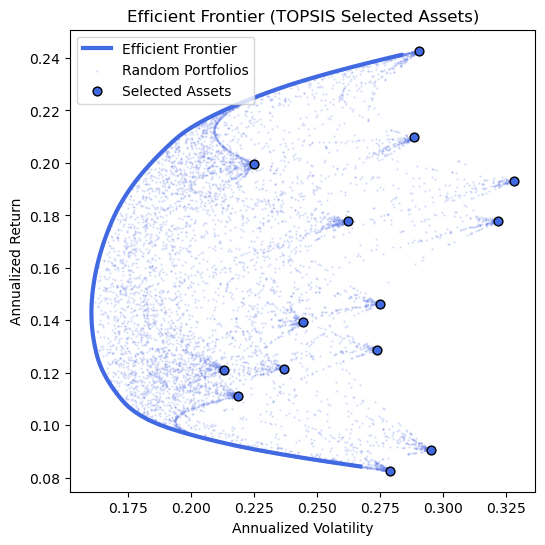

In [17]:
plt.figure(figsize=(6, 6))

# Efficient Frontier from CVXPY
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color='royalblue',
    linewidth=3,
    label="Efficient Frontier"
)

# Global + Stratified random portfolios
plt.scatter(
    port_df['Volatility'],
    port_df['Return'],
    s=0.5,
    c='#6881E7',
    alpha=0.2,
    label="Random Portfolios"
)

# Individual selected assets (tickers)
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors='royalblue',
    edgecolors='k',
    linewidths=1,
    s=40,
    label="Selected Assets"
)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier (TOPSIS Selected Assets)")
plt.legend()

plt.savefig('Results/Portfolio_Frontier.png', dpi=144, transparent=True)
plt.show()


In [19]:
## MIQP (actually continuous relaxation)
esg_min = 30
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# Align info
df_info_sel = df_info_sel.set_index("Ticker").loc[selected_tickers].reset_index()

esg_sel = df_info_sel["ESG_Score"].values
sectors_sel = df_info_sel["Category"].tolist()
unique_sectors_sel = sorted(set(sectors_sel))

In [21]:
# Data prep
mu_np = np.array(mu_sel).flatten()
Sigma_np = np.array(df_cov_sel) * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = np.array(esg_sel).flatten()
n_assets = len(mu_np)

frontier_esg = []
grid = np.linspace(mu_np.min(), mu_np.max(), 30)

sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors_sel])
    for sec in unique_sectors_sel
]

for tr in tqdm(grid, desc="Building ESG frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)  # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,            # <-- use >= not ==
        esg_np @ w >= esg_min,

        # selection constraints (continuous)
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max weight per asset
        w <= max_w_per_asset
    ]

    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_esg.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })
    except Exception as e:
        print(f"Solver Error: {e}")
        continue

frontier_esg_df = pd.DataFrame(frontier_esg)

Building ESG frontier: 100%|███████████████████| 30/30 [00:00<00:00, 106.36it/s]


In [23]:
frontier_esg_df['weights']

0     [0.04961230414438539, 0.09885011366918091, 0.0...
1     [0.04961230414438539, 0.09885011366918091, 0.0...
2     [0.04961230414438539, 0.09885011366918091, 0.0...
3     [0.04961230414438539, 0.09885011366918091, 0.0...
4     [0.04961230414438539, 0.09885011366918091, 0.0...
5     [0.04961230414438539, 0.09885011366918091, 0.0...
6     [0.04961230414438539, 0.09885011366918091, 0.0...
7     [0.04961230414438539, 0.09885011366918091, 0.0...
8     [0.04961230414438539, 0.09885011366918091, 0.0...
9     [0.04961230414438539, 0.09885011366918091, 0.0...
10    [0.04961230414438539, 0.09885011366918091, 0.0...
11    [0.04961230414438539, 0.09885011366918091, 0.0...
12    [0.059766208449775725, 0.10321714532049779, 0....
13    [0.06930685748497274, 0.1150716913287601, 1.52...
14    [0.07957230113179303, 0.13233594182507172, 0.0...
15    [0.08953796762356896, 0.17459722142957418, 0.0...
16    [0.20000000000000015, 0.20000000000000037, 0.0...
Name: weights, dtype: object

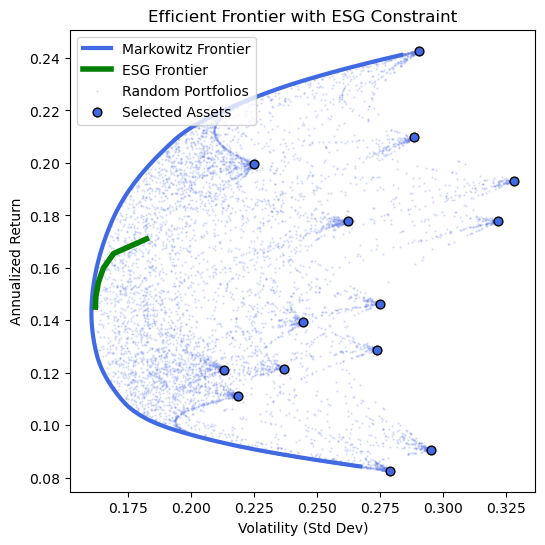

In [25]:
# --- asset stats for TOPSIS selected tickers ---
asset_returns = mu_sel.values
asset_stdevs = df_return_sel.std(axis=0) * np.sqrt(252)

plt.figure(figsize=(6, 6))

# efficient frontier without ESG
plt.plot(frontier_df["stdev"], frontier_df["achieved_return"],
         color='royalblue', linewidth=3, label="Markowitz Frontier")

# efficient frontier with ESG
plt.plot(frontier_esg_df["stdev"], frontier_esg_df["achieved_return"],
         color='green', linewidth=4, label="ESG Frontier")

# scatter of random portfolios
plt.scatter(port_df['Volatility'], port_df['Return'],
            s=0.5, c='#6881E7', alpha=0.2, label="Random Portfolios")

# scatter of individual assets (TOPSIS selected)
plt.scatter(asset_stdevs, asset_returns,
            facecolors='royalblue', edgecolors='k', linewidths=1, s=40,
            label="Selected Assets")

plt.legend()
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with ESG Constraint")

plt.savefig('Results/Portfolio_Frontier_ESG.png', dpi=144, transparent=True)
plt.show()


In [26]:
## Brown Portfolio

In [29]:
esg_max = 30

In [31]:
# ---------------------------------------------------
# Brown / Low-ESG Efficient Frontier (Relaxed)
# ---------------------------------------------------

esg_max = 30                 # LOW ESG threshold (Brown)
max_w_per_asset = 0.20
min_w_if_selected = 0.0001
max_w_per_sector = 0.25
min_n_assets = 5

# --- DATA SETUP (TOPSIS-selected universe) ---
mu_np = mu_sel.values
Sigma_np = df_cov_sel.values * 252
Sigma_np = (Sigma_np + Sigma_np.T) / 2

esg_np = esg_sel
sectors = sectors_sel
unique_sectors = unique_sectors_sel

n_assets = len(mu_np)

# Safety: small diagonal ridge
Sigma_np += np.eye(n_assets) * 1e-6

# Precompute sector masks
sector_masks = [
    np.array([1 if sct == sec else 0 for sct in sectors])
    for sec in unique_sectors
]

frontier_brown = []

# Target return grid
grid = np.linspace(mu_np.min(), mu_np.max() * 0.9, 30)

# --- Optimization Loop ---
for tr in tqdm(grid, desc="Building Brown (Low-ESG) Frontier"):

    w = cp.Variable(n_assets)
    y = cp.Variable(n_assets)   # continuous relaxation

    risk = cp.quad_form(w, cp.psd_wrap(Sigma_np))

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        mu_np @ w >= tr,
        esg_np @ w <= esg_max,          # LOW ESG constraint

        # selection constraints
        y >= 0,
        y <= 1,
        cp.sum(y) >= min_n_assets,
        w <= y,
        w >= min_w_if_selected * y,

        # max per asset
        w <= max_w_per_asset
    ]

    # sector caps
    for mask in sector_masks:
        constraints.append(mask @ w <= max_w_per_sector)

    objective = cp.Minimize(risk + 0.001 * cp.sum(y))

    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.OSQP, warm_start=True)

        if prob.status == cp.OPTIMAL:
            w_val = np.array(w.value).flatten()
            w_val[w_val < 1e-6] = 0

            p_ret = float(mu_np @ w_val)
            p_var = float(w_val @ Sigma_np @ w_val)

            frontier_brown.append({
                "target_return": tr,
                "achieved_return": p_ret,
                "variance": p_var,
                "stdev": np.sqrt(p_var),
                "weights": w_val
            })

    except Exception as e:
        print(f"Solver error at tr={tr:.4f}: {e}")
        continue

frontier_brown_df = pd.DataFrame(frontier_brown)


Building Brown (Low-ESG) Frontier: 100%|███████| 30/30 [00:00<00:00, 178.48it/s]


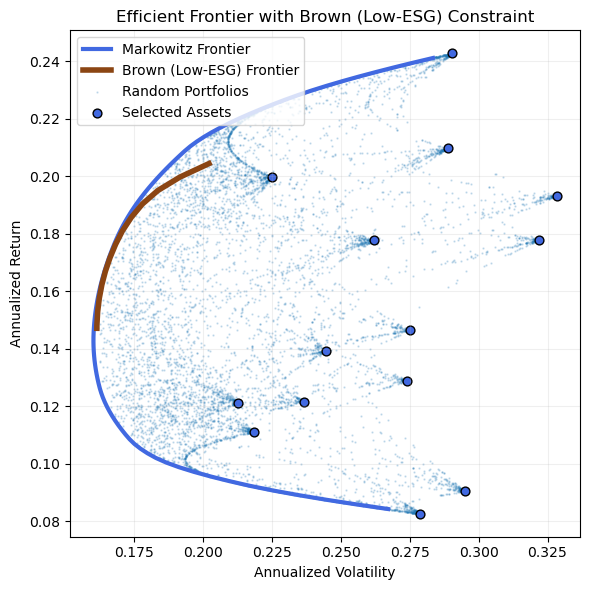

In [33]:
plt.figure(figsize=(6, 6))

# --- Markowitz frontier (no ESG) ---
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=3,
    label="Markowitz Frontier"
)

# --- Brown (Low-ESG) frontier ---
plt.plot(
    frontier_brown_df["stdev"],
    frontier_brown_df["achieved_return"],
    color="saddlebrown",
    linewidth=4,
    label="Brown (Low-ESG) Frontier"
)

# --- Random portfolios ---
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=0.5,
    alpha=0.2,
    label="Random Portfolios"
)

# --- Individual assets (TOPSIS-selected) ---
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1,
    s=40,
    label="Selected Assets"
)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with Brown (Low-ESG) Constraint")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("Results/Portfolio_Frontier_ESG_Brown.png", dpi=144, transparent=True)
plt.show()


In [34]:
# ---------------------------------------------------
# Sort ESG frontiers for correct plotting
# ---------------------------------------------------

frontier_esg_df = (
    frontier_esg_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)

frontier_brown_df = (
    frontier_brown_df
    .dropna()
    .sort_values(by="achieved_return", ascending=True)
    .reset_index(drop=True)
)


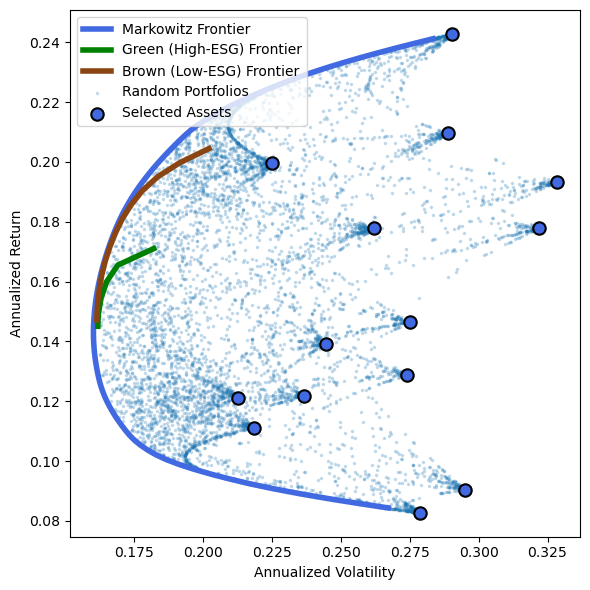

In [37]:
plt.figure(figsize=(6, 6))

# -------------------------------------------------
# Efficient Frontiers (already sorted by return)
# -------------------------------------------------
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=4,
    label="Markowitz Frontier"
)

plt.plot(
    frontier_esg_df["stdev"],
    frontier_esg_df["achieved_return"],
    color="green",
    linewidth=4,
    label="Green (High-ESG) Frontier"
)

plt.plot(
    frontier_brown_df["stdev"],
    frontier_brown_df["achieved_return"],
    color="saddlebrown",
    linewidth=4,
    label="Brown (Low-ESG) Frontier"
)

# -------------------------------------------------
# Random Portfolios Cloud
# -------------------------------------------------
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=2.5,
    alpha=0.2,
    label="Random Portfolios"
)

# -------------------------------------------------
# Individual Assets (TOPSIS-selected)
# -------------------------------------------------
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1.5,
    s=80,
    label="Selected Assets"
)

# -------------------------------------------------
# Labels & Layout
# -------------------------------------------------
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.tight_layout()

plt.savefig(
    "Results/Portfolio_Frontier_ESG_Brown_Zoom.png",
    dpi=144,
    transparent=True
)

plt.show()


In [38]:
## Benchmark

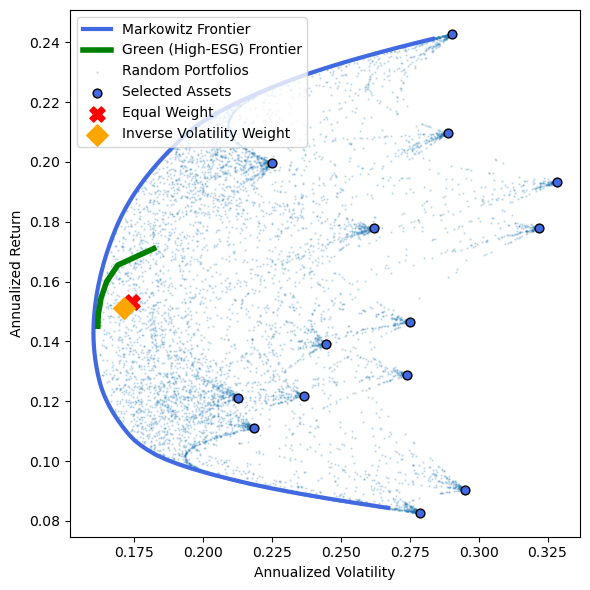

In [39]:
# -------------------------------------------------
# Benchmarks (TOPSIS-selected universe)
# -------------------------------------------------

# Equal-weight portfolio
n_assets = len(mu_sel)
w_ew = np.ones(n_assets) / n_assets
ret_ew = float(mu_sel.values @ w_ew)
vol_ew = float(np.sqrt(w_ew @ (df_cov_sel.values * 252) @ w_ew))

# Inverse-volatility-weighted portfolio
asset_vols = df_return_sel.std(axis=0).values * np.sqrt(252)
inv_vol = 1.0 / asset_vols
w_ivw = inv_vol / inv_vol.sum()

ret_ivw = float(mu_sel.values @ w_ivw)
vol_ivw = float(np.sqrt(w_ivw @ (df_cov_sel.values * 252) @ w_ivw))

# -------------------------------------------------
# Plot
# -------------------------------------------------
plt.figure(figsize=(6, 6))

# Efficient frontiers
plt.plot(
    frontier_df["stdev"],
    frontier_df["achieved_return"],
    color="royalblue",
    linewidth=3,
    label="Markowitz Frontier"
)

plt.plot(
    frontier_esg_df["stdev"],
    frontier_esg_df["achieved_return"],
    color="green",
    linewidth=4,
    label="Green (High-ESG) Frontier"
)

# Random portfolios cloud
plt.scatter(
    port_df["Volatility"],
    port_df["Return"],
    s=0.5,
    alpha=0.2,
    label="Random Portfolios"
)

# Individual assets
plt.scatter(
    asset_stdevs,
    asset_returns,
    facecolors="royalblue",
    edgecolors="k",
    linewidths=1,
    s=40,
    label="Selected Assets"
)

# Benchmarks
plt.scatter(
    vol_ew,
    ret_ew,
    c="red",
    marker="X",
    s=120,
    label="Equal Weight"
)

plt.scatter(
    vol_ivw,
    ret_ivw,
    c="orange",
    marker="D",
    s=120,
    label="Inverse Volatility Weight"
)

# Labels & layout
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend(loc="best")
plt.tight_layout()

plt.savefig(
    "Results/ESG_Frontier_vs_Benchmarks.png",
    dpi=144,
    transparent=True
)

plt.show()


In [43]:
## Output

In [45]:
def parse_weights(w):
    if isinstance(w, str):
        return np.fromstring(w.strip("[]"), sep=" ")
    elif isinstance(w, (list, np.ndarray)):
        return np.array(w, dtype=float)
    else:
        raise ValueError(f"Unexpected weights type: {type(w)}")

def expand_frontier(df_in, asset_cols, out_path):
    """
    Expands a frontier DataFrame by unpacking portfolio weights
    into individual asset columns.
    """
    # Extract weight matrix
    wmat = np.vstack(df_in["weights"].apply(parse_weights).to_numpy())

    # Safety check
    if wmat.shape[1] != len(asset_cols):
        raise ValueError(
            f"Weight dimension mismatch: "
            f"{wmat.shape[1]} weights vs {len(asset_cols)} asset columns"
        )

    # Build expanded DataFrame
    wdf = pd.DataFrame(wmat, columns=asset_cols, index=df_in.index)
    df_out = pd.concat([df_in.drop(columns=["weights"]), wdf], axis=1)

    # Save
    df_out.to_csv(out_path, index=False)
    return df_out

asset_cols = df_return_sel.columns.tolist()

frontier_expanded = expand_frontier(
    frontier_df,
    asset_cols,
    "Results/frontier_markowitz_expanded.csv"
)

frontier_esg_expanded = expand_frontier(
    frontier_esg_df,
    asset_cols,
    "Results/frontier_green_expanded.csv"
)

frontier_brown_expanded = expand_frontier(
    frontier_brown_df,
    asset_cols,
    "Results/frontier_brown_expanded.csv"
)


In [47]:
# -------------------------------------------------
# Export expanded frontiers (project-consistent)
# -------------------------------------------------

frontier_expanded.to_csv(
    "Results/frontier_markowitz_expanded.csv",
    index=False
)

frontier_esg_expanded.to_csv(
    "Results/frontier_green_expanded.csv",
    index=False
)

frontier_brown_expanded.to_csv(
    "Results/frontier_brown_expanded.csv",
    index=False
)


In [49]:
## Tangency Portfolio

In [129]:
# ============================================================
# Tangency Portfolios (Maximum Sharpe Ratio)
# ============================================================

rf = 0.00012  # annualized risk-free rate (keep consistent)

asset_cols = df_return_sel.columns.tolist()
os.makedirs("Results/Tangency", exist_ok=True)

def scalarize(x):
    """Convert arrays/lists to a single scalar float."""
    arr = np.array(x).ravel()
    if arr.size == 0:
        return np.nan
    return float(arr[0])

def vectorize_weights(w):
    """Convert weights to 1D numpy array."""
    if isinstance(w, str):
        w = w.strip("[]")
        w = np.array(w.split(), dtype=float)
    else:
        w = np.array(w).ravel()
    return w.astype(float)

def compute_tangency(frontier_df, rf):
    df = frontier_df.copy()

    # Force scalar values
    df["stdev"] = pd.to_numeric(df["stdev"], errors="coerce")
    df["achieved_return"] = pd.to_numeric(df["achieved_return"], errors="coerce")

    # Compute Sharpe
    df["sharpe"] = (df["achieved_return"] - rf) / df["stdev"]

    # ONLY clean sharpe column (no replace on full df)
    df = df[np.isfinite(df["sharpe"])]

    idx = df["sharpe"].idxmax()

    w = vectorize_weights(df.loc[idx, "weights"])
    ret = float(df.loc[idx, "achieved_return"])
    vol = float(df.loc[idx, "stdev"])
    sharpe = float(df.loc[idx, "sharpe"])

    return w, ret, vol, sharpe


# ------------------------------------------------------------
# Tangency portfolios
# ------------------------------------------------------------
tan_w, tan_ret, tan_vol, tan_sharpe = compute_tangency(frontier_df, rf)
tan_w_esg, tan_ret_esg, tan_vol_esg, tan_sharpe_esg = compute_tangency(frontier_esg_df, rf)
tan_w_b, tan_ret_b, tan_vol_b, tan_sharpe_b = compute_tangency(frontier_brown_df, rf)

# ------------------------------------------------------------
# Export weights
# ------------------------------------------------------------
pd.DataFrame({"asset": asset_cols, "weight": tan_w}).to_csv(
    "Results/Tangency/tangency_markowitz_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_esg}).to_csv(
    "Results/Tangency/tangency_green_weights.csv", index=False)

pd.DataFrame({"asset": asset_cols, "weight": tan_w_b}).to_csv(
    "Results/Tangency/tangency_brown_weights.csv", index=False)

# ------------------------------------------------------------
# Export summaries
# ------------------------------------------------------------
summary_df = pd.DataFrame([
    {"frontier": "markowitz", "rf": rf, "return": tan_ret, "volatility": tan_vol, "sharpe": tan_sharpe},
    {"frontier": "green",     "rf": rf, "return": tan_ret_esg, "volatility": tan_vol_esg, "sharpe": tan_sharpe_esg},
    {"frontier": "brown",     "rf": rf, "return": tan_ret_b, "volatility": tan_vol_b, "sharpe": tan_sharpe_b}
])

summary_df.to_csv("Results/Tangency/tangency_summary.csv", index=False)


In [131]:
import matplotlib.pyplot as plt

def plot_frontier(
    title,
    filename,
    frontiers,
    mc_df,
    asset_returns,
    asset_stdevs,
    rf,
    tangencies,
    benchmarks=None,
    xlim=None,
    ylim=None,
    figsize=(6,6)
):
    plt.figure(figsize=figsize)

    # Plot frontiers
    for f in frontiers:
        plt.plot(
            f["stdev"],
            f["achieved_return"],
            linewidth=f.get("lw", 3),
            color=f["color"],
            label=f["label"]
        )

    # MC portfolios
    plt.scatter(
        mc_df["Volatility"], mc_df["Return"],
        s=0.5, c='#6881E7', alpha=0.2, label="MC Portfolios"
    )

    # Assets
    plt.scatter(
        asset_stdevs, asset_returns,
        facecolors='royalblue', edgecolors='k',
        linewidths=1, s=40, label="Assets"
    )

    # Tangency points and CAL
    for t in tangencies:
        plt.scatter(
            t["vol"], t["ret"],
            c=t["color"], edgecolors='k', marker='*',
            s=t.get("size", 250), linewidths=2.5, label=t["label"]
        )
        plt.plot(
            [0, t["vol"]],
            [rf, t["ret"]],
            linestyle='--',
            color='gray',
            linewidth=2.5,
            label=f'CAL ({t["label"]})'
        )

    # Benchmarks
    if benchmarks:
        for b in benchmarks:
            plt.scatter(
                b["vol"], b["ret"],
                c=b["color"],
                marker=b["marker"],
                s=b["s"],
                label=b["label"]
            )

    plt.scatter(0, rf, facecolors='none', edgecolors='k', s=40,
                linewidths=2, label='Risk-Free Asset')

    plt.title(title)
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Return")
    plt.grid(True)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.legend(loc='best', fontsize=8)
    plt.savefig(f"Results/{filename}", dpi=144, transparent=True)
    plt.show()


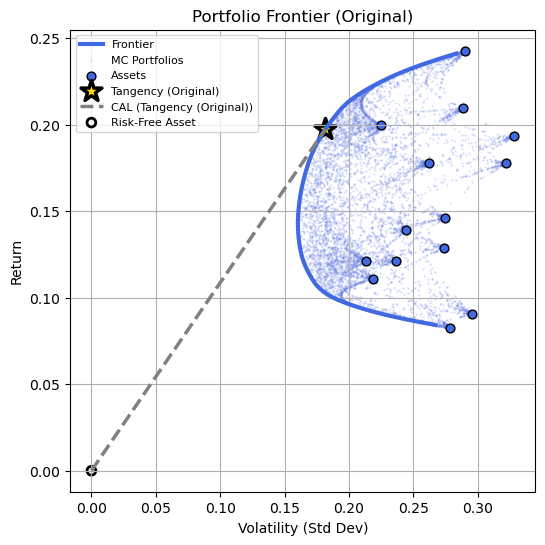

In [133]:
plot_frontier(
    title="Portfolio Frontier (Original)",
    filename="Portfolio_Frontier.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"}
    ]
)


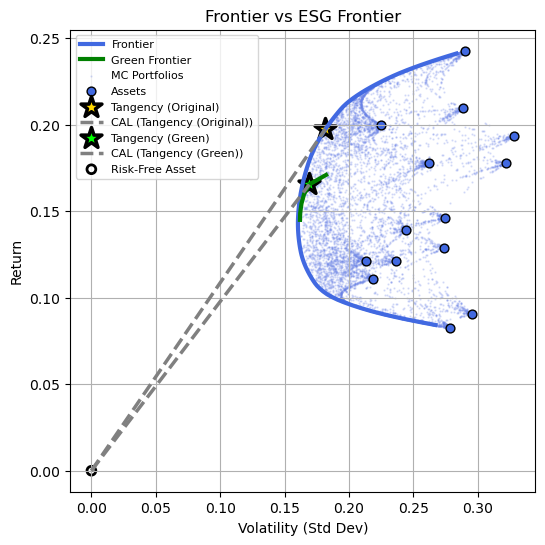

In [84]:
plot_frontier(
    title="Frontier vs ESG Frontier",
    filename="Portfolio_Frontier_ESG.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"],
         "color":"green", "label":"Green Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ]
)


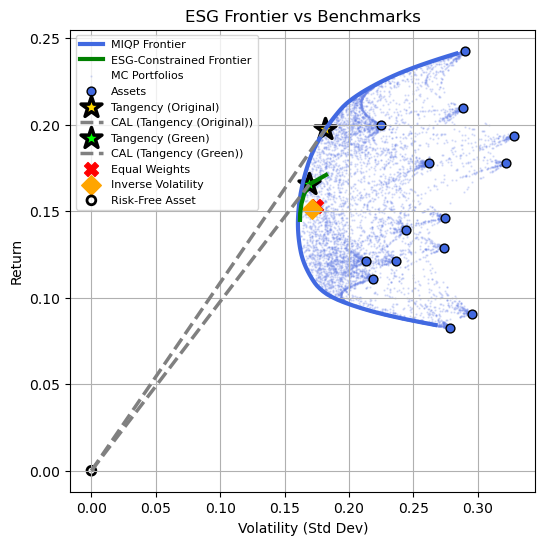

In [86]:
plot_frontier(
    title="ESG Frontier vs Benchmarks",
    filename="ESG_Frontier_vs_Benchmarks.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"],
         "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"],
         "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    benchmarks=[
        {"vol": vol_ew, "ret": ret_ew, "color":"red", "marker":"X", "s":100, "label":"Equal Weights"},
        {"vol": vol_ivw, "ret": ret_ivw, "color":"orange", "marker":"D", "s":100, "label":"Inverse Volatility"}
    ]
)


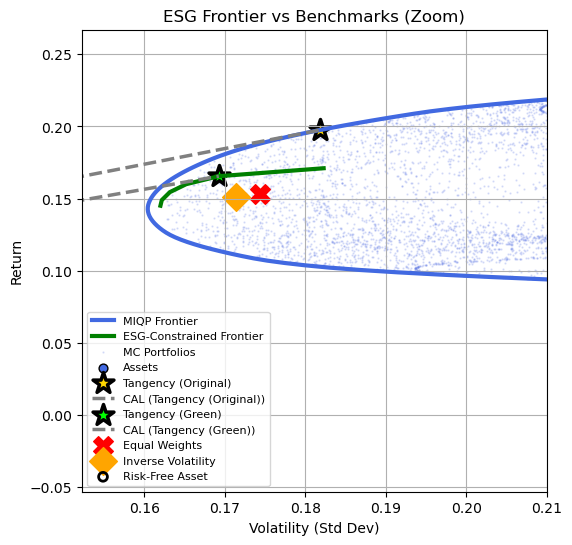

In [88]:
# -------------------------
# Zoom around tangency
# -------------------------
margin = 0.02  # increase if you want wider zoom

mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    tan_vol,
    tan_vol_esg,
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    tan_vol,
    tan_vol_esg,
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    tan_ret,
    tan_ret_esg,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    tan_ret,
    tan_ret_esg
)

# Add padding
pad_x = (x_max - x_min) * 0.25
pad_y = (y_max - y_min) * 0.25

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG Frontier vs Benchmarks (Zoom)",
    filename="ESG_Frontier_vs_Benchmarks_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    benchmarks=[
        {"vol": vol_ew, "ret": ret_ew, "color":"red", "marker":"X", "s":200, "label":"Equal Weights"},
        {"vol": vol_ivw, "ret": ret_ivw, "color":"orange", "marker":"D", "s":200, "label":"Inverse Volatility"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


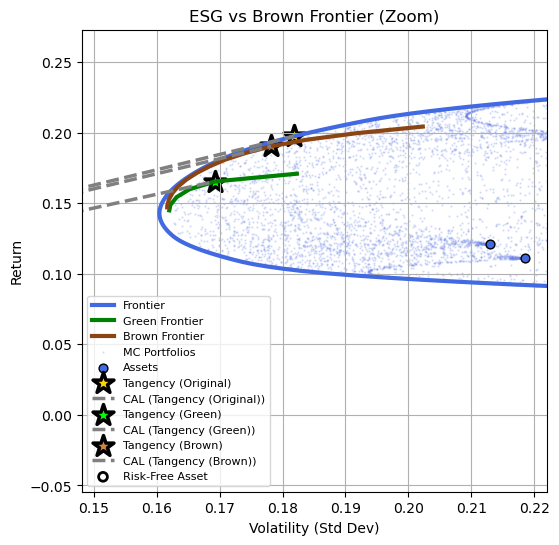

In [115]:
# -------------------------
# Zoom around tangency + small slice of frontier
# -------------------------
margin = 0.03   # increase for larger zoom, decrease for tighter zoom
pad_ratio = 0.25  # controls how much padding around the min/max

# --- slice around tangency ---
mask_blue  = (frontier_df["stdev"] >= tan_vol - margin) & (frontier_df["stdev"] <= tan_vol + margin)
mask_green = (frontier_esg_df["stdev"] >= tan_vol_esg - margin) & (frontier_esg_df["stdev"] <= tan_vol_esg + margin)
mask_brown = (frontier_brown_df["stdev"] >= tan_vol_b - margin) & (frontier_brown_df["stdev"] <= tan_vol_b + margin)

x_min = min(
    frontier_df.loc[mask_blue, "stdev"].min(),
    frontier_esg_df.loc[mask_green, "stdev"].min(),
    frontier_brown_df.loc[mask_brown, "stdev"].min(),
    tan_vol, tan_vol_esg, tan_vol_b
)

x_max = max(
    frontier_df.loc[mask_blue, "stdev"].max(),
    frontier_esg_df.loc[mask_green, "stdev"].max(),
    frontier_brown_df.loc[mask_brown, "stdev"].max(),
    tan_vol, tan_vol_esg, tan_vol_b
)

y_min = min(
    frontier_df.loc[mask_blue, "achieved_return"].min(),
    frontier_esg_df.loc[mask_green, "achieved_return"].min(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].min(),
    tan_ret, tan_ret_esg, tan_ret_b,
    rf
)

y_max = max(
    frontier_df.loc[mask_blue, "achieved_return"].max(),
    frontier_esg_df.loc[mask_green, "achieved_return"].max(),
    frontier_brown_df.loc[mask_brown, "achieved_return"].max(),
    tan_ret, tan_ret_esg, tan_ret_b
)

# Add padding
pad_x = (x_max - x_min) * pad_ratio
pad_y = (y_max - y_min) * pad_ratio

xlim_zoom = (x_min - pad_x, x_max + pad_x)
ylim_zoom = (y_min - pad_y, y_max + pad_y)


# -------------------------
# Plot
# -------------------------
plot_frontier(
    title="ESG vs Brown Frontier (Zoom)",
    filename="Portfolio_Frontier_ESG_Brown_Zoom.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ],
    xlim=xlim_zoom,
    ylim=ylim_zoom
)


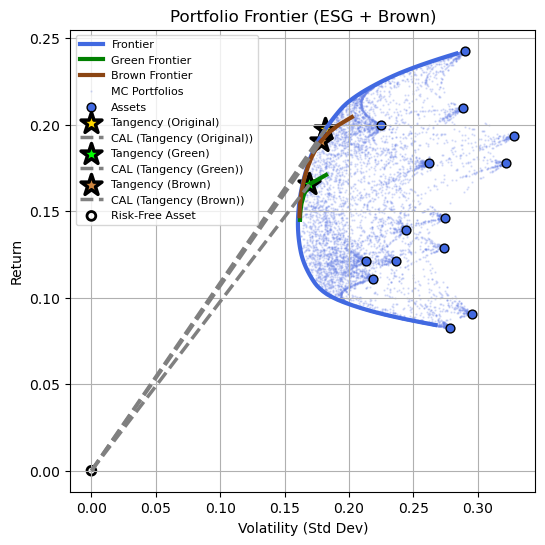

In [93]:
plot_frontier(
    title="Portfolio Frontier (ESG + Brown)",
    filename="Portfolio_Frontier_ESG_Brown.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"Green Frontier"},
        {"stdev": frontier_brown_df["stdev"], "achieved_return": frontier_brown_df["achieved_return"], "color":"saddlebrown", "label":"Brown Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"},
        {"vol": tan_vol_b, "ret": tan_ret_b, "color":"peru", "label":"Tangency (Brown)"}
    ]
)


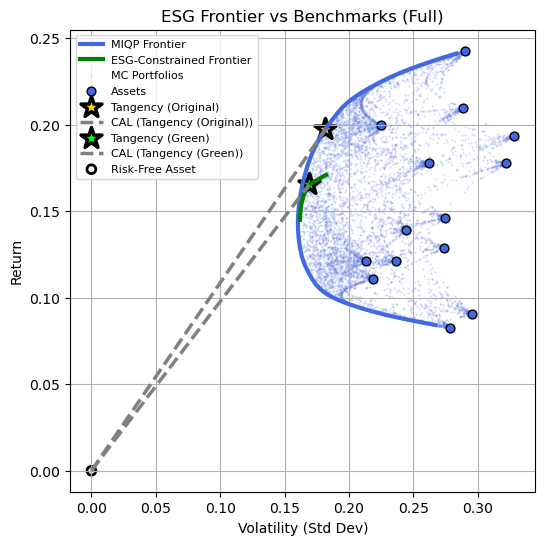

In [95]:
x_min = min(
    port_df["Volatility"].min(),
    frontier_df["stdev"].min(),
    frontier_esg_df["stdev"].min(),
    0  # <-- include risk-free x
)

x_max = max(
    port_df["Volatility"].max(),
    frontier_df["stdev"].max(),
    frontier_esg_df["stdev"].max()
)

y_min = min(
    port_df["Return"].min(),
    frontier_df["achieved_return"].min(),
    frontier_esg_df["achieved_return"].min(),
    rf  # <-- include risk-free y
)

y_max = max(
    port_df["Return"].max(),
    frontier_df["achieved_return"].max(),
    frontier_esg_df["achieved_return"].max()
)

pad_x = (x_max - x_min) * 0.05
pad_y = (y_max - y_min) * 0.05

xlim_full = (x_min - pad_x, x_max + pad_x)
ylim_full = (y_min - pad_y, y_max + pad_y)

plot_frontier(
    title="ESG Frontier vs Benchmarks (Full)",
    filename="ESG_Frontier_vs_Benchmarks_Full.png",
    frontiers=[
        {"stdev": frontier_df["stdev"], "achieved_return": frontier_df["achieved_return"], "color":"royalblue", "label":"MIQP Frontier"},
        {"stdev": frontier_esg_df["stdev"], "achieved_return": frontier_esg_df["achieved_return"], "color":"green", "label":"ESG-Constrained Frontier"}
    ],
    mc_df=port_df,
    asset_returns=asset_returns,
    asset_stdevs=asset_stdevs,
    rf=rf,
    tangencies=[
        {"vol": tan_vol, "ret": tan_ret, "color":"gold", "label":"Tangency (Original)"},
        {"vol": tan_vol_esg, "ret": tan_ret_esg, "color":"lime", "label":"Tangency (Green)"}
    ],
    xlim=xlim_full,
    ylim=ylim_full
)


In [97]:
def compute_metrics(returns, rf=0.00012):
    returns = pd.Series(returns).dropna()

    if len(returns) < 2:
        return {k: np.nan for k in [
            "annual_return","volatility","sharpe","sortino",
            "max_drawdown","calmar","cvar_95","rachev_95"
        ]}

    ann_factor = 252
    mean_ret = returns.mean() * ann_factor
    vol = returns.std(ddof=1) * np.sqrt(ann_factor)

    sharpe = (mean_ret - rf) / vol if vol != 0 else np.nan

    downside = returns[returns < 0]
    downside_std = downside.std(ddof=1) * np.sqrt(ann_factor)
    sortino = (mean_ret - rf) / downside_std if downside_std != 0 else np.nan

    # Max Drawdown
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    calmar = mean_ret / abs(max_dd) if max_dd != 0 else np.nan

    # CVaR 95% and Rachev
    alpha = 0.05
    var = returns.quantile(alpha)
    cvar = returns[returns <= var].mean()

    up_var = returns.quantile(1-alpha)
    cvar_up = returns[returns >= up_var].mean()

    rachev = cvar_up / abs(cvar) if cvar != 0 else np.nan

    return {
        "annual_return": mean_ret,
        "volatility": vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_dd,
        "calmar": calmar,
        "cvar_95": cvar,
        "rachev_95": rachev
    }


In [99]:
def portfolio_returns(weights, asset_returns_df):
    weights = np.array(weights).flatten()

    # asset_returns_df must be DataFrame with shape (n_days, n_assets)
    if asset_returns_df.shape[1] != len(weights):
        raise ValueError(
            f"Mismatch: asset_returns has {asset_returns_df.shape[1]} columns but weights length is {len(weights)}"
        )

    return asset_returns_df @ weights


In [105]:
ret_tan = portfolio_returns(tan_w, df_return_sel)
ret_tan_esg = portfolio_returns(tan_w_esg, df_return_sel)
ret_tan_brown = portfolio_returns(tan_w_b, df_return_sel)

metrics_tan = compute_metrics(ret_tan, rf=rf)
metrics_tan_esg = compute_metrics(ret_tan_esg, rf=rf)
metrics_tan_brown = compute_metrics(ret_tan_brown, rf=rf)

print(metrics_tan)
print(metrics_tan_esg)
print(metrics_tan_brown)


{'annual_return': 0.19749861620760784, 'volatility': 0.1818122940292735, 'sharpe': 1.085617544519998, 'sortino': 1.312522888724085, 'max_drawdown': -0.35054558127766083, 'calmar': 0.563403525121524, 'cvar_95': -0.027614979483718854, 'rachev_95': 0.9170528465780012}
{'annual_return': 0.1654924724610598, 'volatility': 0.16924191200280916, 'sharpe': 0.977136635388017, 'sortino': 1.1781311356070483, 'max_drawdown': -0.33871114962094456, 'calmar': 0.4885946997796331, 'cvar_95': -0.026343135688018646, 'rachev_95': 0.8964840839611802}
{'annual_return': 0.1903997158798398, 'volatility': 0.17816735876105413, 'sharpe': 1.0679830312522618, 'sortino': 1.3006446190589187, 'max_drawdown': -0.3382943140286503, 'calmar': 0.5628226901375433, 'cvar_95': -0.027177699478577063, 'rachev_95': 0.9134120314786844}


In [107]:
df_metrics = pd.DataFrame([
    {"Portfolio": "Tangency", **metrics_tan},
    {"Portfolio": "Tangency ESG", **metrics_tan_esg},
    {"Portfolio": "Tangency Brown", **metrics_tan_brown}
])

df_metrics


,Portfolio,annual_return,volatility,sharpe,sortino,max_drawdown,calmar,cvar_95,rachev_95
0,Tangency,0.197499,0.181812,1.085618,1.312523,-0.350546,0.563404,-0.027615,0.917053
1,Tangency ESG,0.165492,0.169242,0.977137,1.178131,-0.338711,0.488595,-0.026343,0.896484
2,Tangency Brown,0.190400,0.178167,1.067983,1.300645,-0.338294,0.562823,-0.027178,0.913412
